- SRCNN - Super Resolution Convolutional Neural netrwork
  - 최초의 cnn 기반 초해상도 모델
  - 입력 이미지를 업샘플링 후 cnn을 적용해서 고해상도 이미지를 생성
  - 학습과정이 단순하지만 성능이 비교적 제한
- GAN 기반 모델(SRGANm ESRGAN)
  - 생성적 적대 신경망(GAN)을 사용해서 초해상도를 학습
  - 생성자와 판별자를 경쟁적으로 학습시켜 더 세밀하고 사실적인 결과를 얻음
  - 최근의 초해상도 연구에서 가장 많이 사용  


- SRCNN VS GAN 기반 모델 비교
  - 비교항목   |       SRCNN                   |           GAN
  -  구조      |     단순한 CNN                |          생성자 + 판별자
  -  속도      |     빠름                      |          느림
  - 해상도 개선|     비교적 단순한 업스케일링  |        디데일까지 세밀한 초해상도
  - 학습방식   |      L2 손실(MSE) 기반        |        GAN + Peceptual Loss

SRCNN 수퍼 해상도 코드

In [1]:
# 필요 라이브러리 설치
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def build_srcnn():
  model = keras.Sequential([
    layers.Conv2D(64, (9,9),  padding='same', activation='relu', input_shape=(None,None,3)),
    layers.Conv2D(32, (5,5),  padding='same', activation='relu'),
    layers.Conv2D(3, (5,5),  padding='same', activation='linear'),
  ])
  return model

In [3]:
# 데이터 전처리 및 이미지 로딩
def load_and_preprocess_image(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (img.shape[1]//2,img.shape[0]//2), interpolation=cv2.INTER_CUBIC) # 저해상도 변환
  img = cv2.resize(img, (img.shape[1]*2,img.shape[0]*2), interpolation=cv2.INTER_CUBIC) # 원래 크기로 복원
  img = img.astype(np.float32) / 255.0 # 정규화
  return np.expand_dims(img, axis=0)  # 배치 차원 추가

In [5]:
# 이미지 가져오기
import requests
from PIL import Image
from io import BytesIO
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/800px-Cat03.jpg'
# 이미지 다운로드
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
# 저해상도 변환
low_res = img.resize((img.width //4, img.height // 4), Image.BICUBIC)
# 원래 크기로 복원
low_res = low_res.resize((img.width, img.height), Image.BICUBIC)
low_res.save('low_res.jpg')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


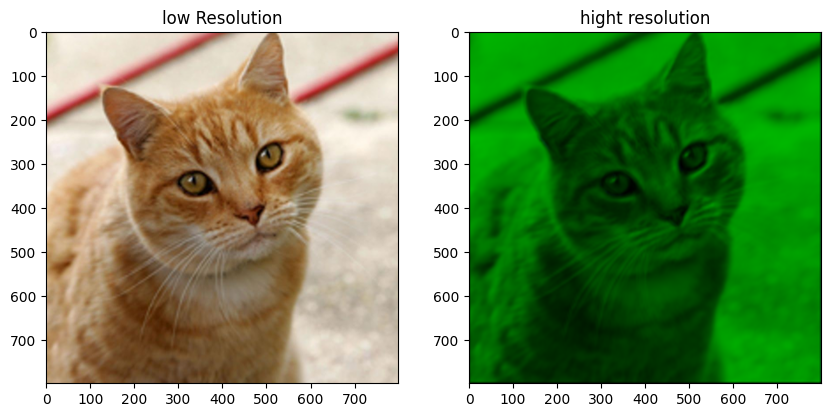

In [6]:
# 모델 학습 및 이미지 변환
# 모델 생성
srcnn = build_srcnn()
srcnn.compile(optimizer='adam', loss='mean_squared_error')

# 저해상도 이미지 로딩
low_res_image_path='/content/low_res.jpg'
low_res_img = load_and_preprocess_image(low_res_image_path)

# srcnn으로 고해상도 이미지  생성
hight_res_img = srcnn.predict(low_res_img)[0]

# 결과 시각화
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("low Resolution")
plt.imshow(low_res_img[0])
plt.subplot(1,2,2)
plt.title('hight resolution')
plt.imshow(np.clip(hight_res_img,0,1))
plt.show()

